In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:0


In [3]:
import random
import numpy as np

# MAKING ALL WEIGHTS OF NN NOT RANDOM, DETERMINISTIC
# TO INVESTIGATE THE TRUE EFFECTIVENESS OF THE MODEL
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



# set_deterministic()
# set_all_seeds(RANDOM_SEED)

In [4]:
# import torch
# from PIL import Image
# from torch.utils.data import Dataset
# from torchvision import transforms
# import pandas as pd


# ## Create a custom Dataset class
# class CelebADataset(Dataset):
#   def __init__(self, root_dir, transform=None):
#     """
#     Args:
#       root_dir (string): Directory with all the images
#       transform (callable, optional): transform to be applied to each image sample
#     """

#     # Path to directory with all the images
#     img_folder = f'{root_dir}/img_align_celeba'
#     image_names = []
#     for dirname, _, filenames in os.walk(img_folder):
#         for filename in filenames:
#             image_names.append(os.path.join(dirname, filename))
#     # print(image_names)
#     # Read names of images in the root directory
#     # image_names = os.listdir(img_folder)
#     self.root_dir = root_dir
#     self.transform = transform 
#     self.image_names = image_names
#     # print(img_folder)
#     # print(image_names)
#     self.attr = pd.read_csv(f'{root_dir}/list_attr_celeba.csv', delimiter=',')


#   def __len__(self): 
#     return len(self.image_names)

#   def __getitem__(self, idx):
#     # Get the path to the image 
#     img_path = self.image_names[idx] # os.path.join(f'{self.root_dir}/img_align_celeba', self.image_names[idx])
#     # Load image and convert it to RGB
#     img = Image.open(img_path).convert('RGB')
#     # Apply transformations to the image
#     if self.transform:
#       img = self.transform(img)
    
#     target = self.attr[idx, :]
#     target = tuple(target) if len(target) > 1 else target[0]
#     print(target)
#     return img, target

# ## Load the dataset 

# # Spatial size of training images, images are resized to this size.
# image_size = 64
# # Transformations to be applied to each individual image sample
# transform=transforms.Compose([
#     torchvision.transforms.CenterCrop((128, 128)),
#     torchvision.transforms.ToTensor(),
# ])
# # Load the dataset from file and apply transformations
# celeba_dataset = CelebADataset("../input/celeba-dataset", transform)

# ## Create a dataloader 

# # Number of workers for the dataloader
# num_workers = 0 if DEVICE.type == 'cuda' else 2
# # Whether to put fetched data tensors to pinned memory
# pin_memory = True if DEVICE.type == 'cuda' else False

# train_loader = torch.utils.data.DataLoader(celeba_dataset,
#                                                 batch_size=BATCH_SIZE,
#                                                 num_workers=num_workers,
#                                                 pin_memory=pin_memory,
#                                                 shuffle=True)

In [5]:
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random


class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        for i, attr_name in enumerate(all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split(",")
            filename = split[0]
            values = split[1:]

            label = []
            for idx in range(len(values)):
                label.append(values[idx] == '1')


            if (i+1) < 2000:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, crop_size=178, image_size=128, 
               batch_size=256, dataset='CelebA', mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
#     transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    if dataset == 'CelebA':
        dataset = CelebA(image_dir, attr_path, transform, mode)
    elif dataset == 'RaFD':
        dataset = ImageFolder(image_dir, transform)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

In [6]:
train_loader = get_loader(image_dir="../input/celeba-dataset/img_align_celeba/img_align_celeba", 
                          attr_path="../input/celeba-dataset/list_attr_celeba.csv"
                         )

Finished preprocessing the CelebA dataset...


In [7]:



# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive 
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry 
11 - Brown_Hair 
12 - Bushy_Eyebrows 
13 - Chubby 
14 - Double_Chin 
15 - Eyeglasses 
16 - Goatee 
17 - Gray_Hair 
18 - Heavy_Makeup 
19 - High_Cheekbones 
20 - Male 
21 - Mouth_Slightly_Open 
22 - Mustache 
23 - Narrow_Eyes 
24 - No_Beard 
25 - Oval_Face 
26 - Pale_Skin 
27 - Pointy_Nose 
28 - Receding_Hairline 
29 - Rosy_Cheeks 
30 - Sideburns 
31 - Smiling 
32 - Straight_Hair 
33 - Wavy_Hair 
34 - Wearing_Earrings 
35 - Wearing_Hat 
36 - Wearing_Lipstick 
37 - Wearing_Necklace 
38 - Wearing_Necktie 
39 - Young         
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

In [8]:


##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded



In [9]:
model = VAE()
print(DEVICE)
# model.load_state_dict(torch.load('vae_celeba_02.pt', map_location=torch.device('cpu')))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

cuda:0


In [10]:
import torch.nn.functional as F
import time

def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_celeba_02.pt')


Epoch: 001/050 | Batch 0000/0784 | Loss: 6014.2417
Epoch: 001/050 | Batch 0050/0784 | Loss: 2281.5129
Epoch: 001/050 | Batch 0100/0784 | Loss: 1575.3031
Epoch: 001/050 | Batch 0150/0784 | Loss: 1422.0724
Epoch: 001/050 | Batch 0200/0784 | Loss: 1263.8176
Epoch: 001/050 | Batch 0250/0784 | Loss: 1200.4528
Epoch: 001/050 | Batch 0300/0784 | Loss: 1204.3990
Epoch: 001/050 | Batch 0350/0784 | Loss: 1153.6274
Epoch: 001/050 | Batch 0400/0784 | Loss: 1094.6410
Epoch: 001/050 | Batch 0450/0784 | Loss: 1047.6284
Epoch: 001/050 | Batch 0500/0784 | Loss: 1092.3591
Epoch: 001/050 | Batch 0550/0784 | Loss: 1050.3840
Epoch: 001/050 | Batch 0600/0784 | Loss: 1031.3375
Epoch: 001/050 | Batch 0650/0784 | Loss: 946.8324
Epoch: 001/050 | Batch 0700/0784 | Loss: 953.2225
Epoch: 001/050 | Batch 0750/0784 | Loss: 918.2161
Time elapsed: 27.99 min
Epoch: 002/050 | Batch 0000/0784 | Loss: 871.3580
Epoch: 002/050 | Batch 0050/0784 | Loss: 894.8890
Epoch: 002/050 | Batch 0100/0784 | Loss: 906.4501
Epoch: 002/05

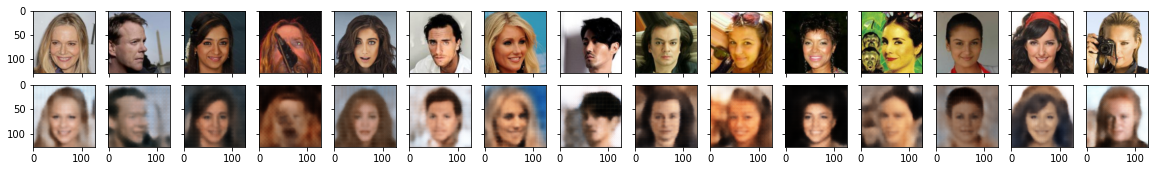

In [11]:
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')



#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')           



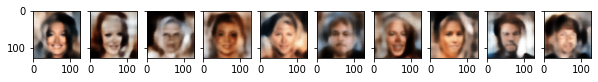

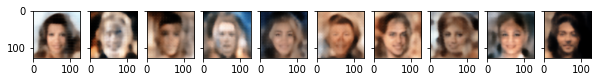

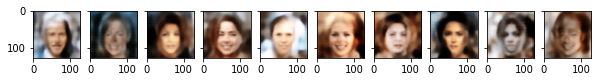

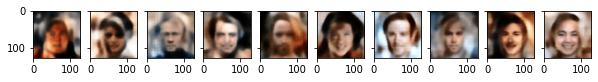

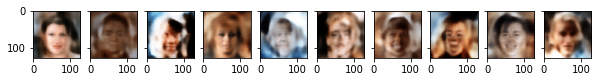

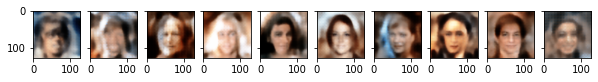

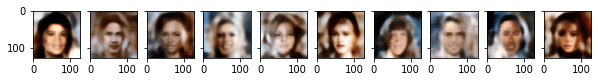

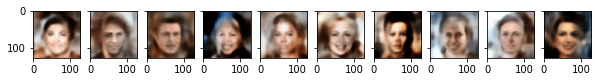

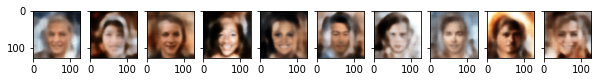

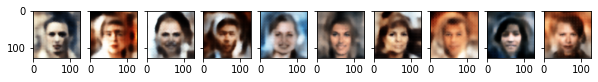

In [12]:
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 
                

for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()


In [13]:
def compute_average_faces(feature_idx, image_dim, data_loader, device=None, encoding_fn=None):

    avg_img_with_feat = torch.zeros(image_dim, dtype=torch.float32)
    avg_img_without_feat = torch.zeros(image_dim, dtype=torch.float32)

    num_img_with_feat = 0
    num_images_without_feat = 0

    for images, labels in data_loader:  
        idx_img_with_feat = labels[:, feature_idx].to(torch.bool)

        if encoding_fn is None:
            embeddings = images
        else:
            ####################################
            ### Get latent representation
            with torch.no_grad():

                if device is not None:
                    images = images.to(device)
                embeddings = encoding_fn(images).to('cpu')
            ####################################    

        avg_img_with_feat += torch.sum(embeddings[idx_img_with_feat], axis=0)
        avg_img_without_feat += torch.sum(embeddings[~idx_img_with_feat], axis=0)
        num_img_with_feat += idx_img_with_feat.sum(axis=0)
        num_images_without_feat += (~idx_img_with_feat).sum(axis=0)

    avg_img_with_feat /= num_img_with_feat
    avg_img_without_feat /= num_images_without_feat
    
    return avg_img_with_feat, avg_img_without_feat

avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=2, # attractive
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)



In [14]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


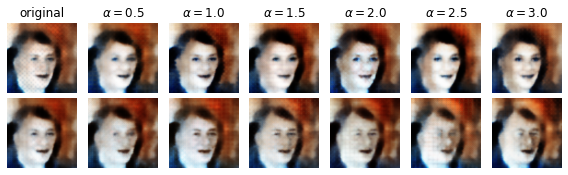

In [15]:
transform = []
transform.append(T.ToTensor())
transform = T.Compose(transform)

# EXAMPLE_IMAGE = transform(Image.open("../input/test-images/sonya.jpg"))

EXAMPLE_IMAGE = images[1]
def plot_modified_faces(original, diff,
                        diff_coefficients=(0., 0.5, 1., 1.5, 2., 2.5, 3.),
                        decoding_fn=None,
                        device=None,
                        figsize=(8, 2.5)):

    fig, axes = plt.subplots(nrows=2, ncols=len(diff_coefficients), 
                             sharex=True, sharey=True, figsize=figsize)
    

    for i, alpha in enumerate(diff_coefficients):
        more = original + alpha*diff
        less = original - alpha*diff
        
        
        if decoding_fn is not None:
            ######################################
            ### Latent -> Original space
            with torch.no_grad():

                if device is not None:
                    more = more.to(device).unsqueeze(0)
                    less = less.to(device).unsqueeze(0)

                more = decoding_fn(more).to('cpu').squeeze(0)
                less = decoding_fn(less).to('cpu').squeeze(0)
            ###################################### 
        
        if not alpha:
            s = 'original'
        else:
            s = f'$\\alpha=${alpha}'
            
        axes[0][i].set_title(s)
        axes[0][i].imshow(more.permute(1, 2, 0))
        axes[1][i].imshow(less.permute(1, 2, 0))
        axes[1][i].axison = False
        axes[0][i].axison = False
        
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()